# Application: One-zone X-ray burst

This is a simple one-zone model of a pure He [X-ray burst](https://en.wikipedia.org/wiki/X-ray_burster).  It follows [Heger, Cumming, & Woosley 2007](https://iopscience.iop.org/article/10.1086/517491) (HCW07), but we consider the accretion to be pure He to simplify the model.  Similar work was explored in [Paczyński 1983](https://articles.adsabs.harvard.edu/pdf/1983ApJ...264..282P), and [Livio & Regev 1985](https://ui.adsabs.harvard.edu/abs/1985A%26A...148..133L/abstract). This simple system can give rise to repeated bursts (and a [limit cycle](https://en.wikipedia.org/wiki/Limit_cycle)) depending on the accretion rate.


The basic idea is that a neutron star accretes pure He from a companion star, building up a layer of fuel.  As this layer grows, the density and temperature at the base become large enough for the 3-$\alpha$ reaction to take place.  This heating competes with radiative cooling (photons carrying the energy to the top of the atmsophere).  Eventually, the heating will exceed the cooling and a thermonuclear runaway takes place (the X-ray burst), consuming the fuel, and then the process repeats.

We want to model this behavior using a single zone representing the accreted layer.

It is traditional to take the accreted layer on the neutron star to be plane parallel,
with constant gravity.  Then we define column depth as:

$$y = \int_{z = 0}^{z = -z_\mathrm{base}} \rho dz$$

where $y = 0$ at the surface of the accreted layer and increases as we move downward through the layer.

With this definition, hydrostatic equilibrium simply becomes:

$$p = |g| y$$

## Equation set

We solve evolution equations for temperature, $T$, and column depth, $y$:

$$
c_p \frac{dT}{dt} =  \epsilon_{3\alpha} + Q_\mathrm{deep} \frac{\dot{m}}{y} - \epsilon_\mathrm{cool}
$$

$$\frac{dy}{dt} = \dot{m} - \frac{\epsilon_{3\alpha}}{Q_{3\alpha}} y$$

where:

* $c_p$ (erg/g/K) is the specific heat at constant pressure
* $\dot{m}$ (g/cm$^2$/s) is the column accretion rate
* $\epsilon_{3\alpha}$ (erg/g/s) is the energy generation rate for the 3-$\alpha$ reaction
* $Q_{3\alpha}$ (erg/g) is the energy release per mass from burning
* $Q_\mathrm{deep}$ (erg/g) is heat release from deep crustal heating and gravitational compression.  This term takes the form of an energy flux, $F = \dot{m} Q_\mathrm{deep}$ (see [Bildsten 1997](https://ui.adsabs.harvard.edu/abs/1998ASIC..515..419B/abstract)).
* $\epsilon_\mathrm{cool}$ (erg/g/s) represents radiative cooling, expressed as an outward radiative energy flux,

  $$\epsilon_\mathrm{cool} \approx \frac{F_\gamma}{y} = \frac{acT^4}{3\kappa y^2}$$

  (again, see [Bildsten 1997](https://ui.adsabs.harvard.edu/abs/1998ASIC..515..419B/abstract))
  where $\kappa$ is the opacity.

The first equation is essentially the first law of thermodynamics, and simply says that the energy increases in the zone due to heat release ($\epsilon_{3\alpha}$ and $Q_\mathrm{deep}$) and decreases due to radiation cooling our zone.

The second equation is conservation of mass. 
where $z_\mathrm{base}$ is the physical depth of the fuel layer.  So $y$ is measuring the mass of the fuel (He in our case) in a column on the surface of the neutron star.  We see that it increases due to accretion of new fuel ($\dot{m}$) and decreases as fuel is burned ($-\epsilon_{3\alpha} y / Q_\mathrm{3\alpha}$).

```{note}
Compared to HCW07, we make the following simplifications:

* We accrete pure He, so there is no hot-CNO term in the energy generation
* We don't modify the energy generation to account for burning to Fe-group
* We ignore radiation in the pressure, and our specific heat only includes ions
* Our opacity is simple constant electron scattering --- we don't worry about T-dependence

Additionally, we find that the crustal heating term is important.
```

## Equation of state

We'll assume an equation of state consisting of ideal gas ions / nuclei:

  $$p_\mathrm{ion} = \frac{\rho k_B T}{\mu_I m_u}$$

and electrons that can be ideal or non-relativisitic degenerate.
The degenerate limit has:

  $$p_{e,\mathrm{deg}} = \frac{h^2}{20 m_e} \left ( \frac{3}{\pi} \right )^{2/3} \left ( \frac{\rho}{\mu_e m_u} \right )^{5/3}$$

while the ideal gas limit has:

  $$p_\mathrm{e,\mathrm{ideal}} = \frac{\rho k_B T}{\mu_e m_u}$$

A common approximation (see [Paczyński 1983](https://ui.adsabs.harvard.edu/abs/1983ApJ...267..315P/abstract)) is to blend these limits as:

$$p_e = \sqrt{p_{e,\mathrm{deg}}^2 + p_{e,\mathrm{ideal}}^2}$$

We also need the specific heat at constant pressure.  We'll
consider only the ions and take:

$$c_p = \frac{5}{2} \frac{k_B}{\mu_I m_u}$$

## Nuclear energy generation

The energy generation comes from triple alpha.
The triple alpha rate is:

$$q_{3\alpha} = 5.09\times 10^{11} \rho^2 Y^3 T_8^{-3} e^{-44.027/T8}~\mathrm{erg/g/s}$$

where $T_8 = T / (10^8~\mathrm{K})$.

The energy release from 3-alpha is 7.275 MeV or 0.606 MeV / nucleon.

## Eddington limit

For a spherical accretor, the Eddington luminosity is:

$$L_\mathrm{Edd} = \frac{4\pi Gc M}{\kappa}$$

and if we look at the accretion luminosity:

$$L_\mathrm{acc} = \frac{G M \dot{M}}{R}$$

we can define the Eddington accretion rate:

$$\dot{M}_\mathrm{Edd} = \frac{4\pi c R}{\kappa}$$

we want the column accretion rate, so we divide this by the surface area:

$$\dot{m}_\mathrm{Edd} = \frac{\dot{M}_\mathrm{Edd}}{4\pi R^2} = \frac{c}{\kappa R}$$

We'll use this as a reference value for the $\dot{m}$ we need
to specify in our problem.

## Implementation

In [1]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import solve_ivp

In [2]:
class XRB:
    """assuming pure He bursts"""
    def __init__(self, mdot=1.0, y_0=1.e8, T_0=2.e8,
                 g=1.9e14, R=1.e6):
        self.mdot = mdot
        self.y_0 = y_0
        self.T_0 = T_0
        self.g = g
        self.R = R
               
        # mean molecular weights
        self.mu_I = 4.0
        self.mu_e = 2.0

        # constants
        self.k_B = 1.38e-16  # erg / K
        self.h = 6.67e-27  # erg s
        self.m_e = 9.11e-28  # g
        self.m_u = 1.66e-24  # g
        self.c = 3.e10  # cm/s
        self.a = 7.56e-15  # erg / cm**3 / K

        # electron degeneracy
        self.K = self.h**2 /(20 * self.m_e) * (3.0 / np.pi)**(2./3.) * self.m_u**(-5./3.)

        # convert the accretion rate to CGS
        mdot_edd = self.c / self.opacity() / self.R
        self.mdot *= mdot_edd

        # energy release / g from 3-alpha
        erg_per_MeV = 1.6e-6
        
        self.Q_3a = 7.275 / 12 * erg_per_MeV / self.m_u

        # crustal heating
        self.Q_crust = 0.15  # MeV / nucleon
        self.Q_crust *= erg_per_MeV / self.m_u
        
    def rho_from_p(self, p, T):
        
        # ions are ideal gas
        p_ion = lambda rho : rho * self.k_B * T / (self.mu_I * self.m_u)

        # electrons can be ideal gas or degenerate -- we use an approximation to blend
        # the two regimes
        p_e_ideal = lambda rho: rho * self.k_B * T / (self.mu_e * self.m_u)
        p_e_deg = lambda rho: self.K * (rho / self.mu_e)**(5./3.)
        p_e = lambda rho: np.sqrt(p_e_ideal(rho)**2 + p_e_deg(rho)**2)

        # root find on p to get necessary rho
        return brentq(lambda rho: p_ion(rho) + p_e(rho) - p, 1.e2, 1.e8)

    def c_p(self, rho, T):
        """specific heat -- we assume ions are all that matters"""
        c_p_ions = 2.5 * self.k_B / (self.mu_I * self.m_u)      
        return c_p_ions

    def opacity(self):
        """electron scattering (no H)"""
        return 0.2

    def energy_generation(self, rho, T):
        T8 = T / 1.e8
        return 5.09e11 * rho**2 / T8**3 * np.exp(-44.027 / T8)

    def rhs(self, t, state):
        T, y = state

        # pressure comes just from plane-parallel approximation
        p = self.g * y

        # find the corresponding density
        rho = self.rho_from_p(p, T)

        # now compute the microphysics
        kappa = self.opacity()
        c_p = self.c_p(rho, T)
        eps = self.energy_generation(rho, T)

        # compute the outward (cooling) flux
        F = self.a * self.c * T**4 / (3.0 * kappa * y)

        dTdt = (1.0 / c_p) * (eps + self.Q_crust * self.mdot / y - F / y)
        dydt = self.mdot - eps / self.Q_3a * y

        return np.array([dTdt, dydt])

    def evolve(self, tmax):
        sol = solve_ivp(self.rhs, [0, tmax], [self.T_0, self.y_0], method="BDF", rtol=1.e-8)
        return sol

## Exploring solutions

Let's create a burst with the default settings and evolve it for an hour

In [3]:
b = XRB()
sol = b.evolve(3600)

In [4]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'T (K)')

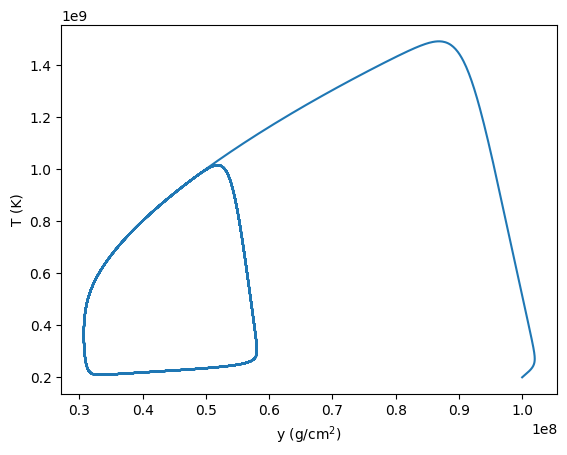

In [5]:
fig, ax = plt.subplots()
ax.plot(sol.y[1,:], sol.y[0,:])
ax.set_xlabel("y (g/cm$^2$)")
ax.set_ylabel("T (K)")

Text(0, 0.5, 'T (K)')

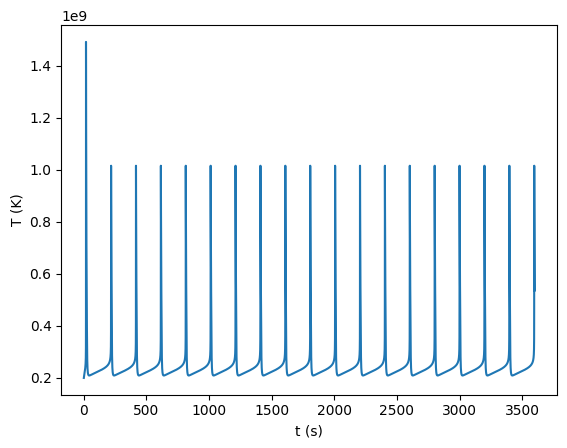

In [6]:
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[0,:])
ax.set_xlabel("t (s)")
ax.set_ylabel("T (K)")

Text(0, 0.5, 'y (g/cm$^2$)')

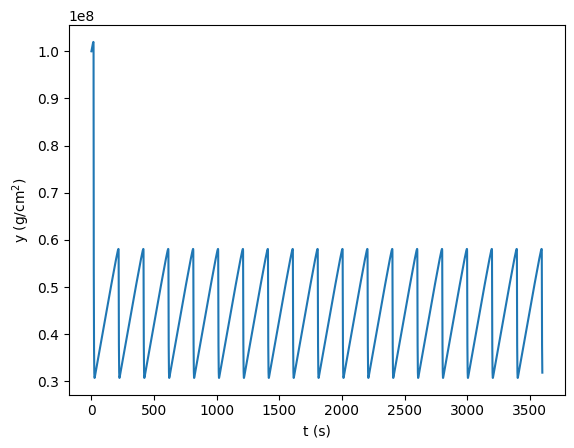

In [7]:
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[1,:])
ax.set_xlabel("t (s)")
ax.set_ylabel("y (g/cm$^2$)")